# Exploring the api transcripts looking for patterns

#### imports
```
    Requires:
        numpy
        pandas
        scipy
        matplotlib
        nltk
        textstat
        seaborn
        plotly
```

In [96]:
import pandas as pd
import numpy as np
import scipy as sp

import glob

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import seaborn as sns

import nltk
from nltk.tokenize import PunktSentenceTokenizer

import textstat

from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

np.random.seed(42)


In [97]:
# Import API-transcribed stories with short columns
DATA_PATH = '../project/data/'
original = pd.read_csv(DATA_PATH + "transcribed_stories.csv", header=0, names=["drop", "s_id", "transcript"], dtype=str).drop("drop", axis=1) # remove unnamed column
original.head()

s_id                                         transcript
0  3132  Page. I 3132 Once there was a little cheatah a...
1  3104  3106 D she was very, a berenang The pony that ...
2  3103  3103 Rainbow the Unica unicom named some een P...
3  3117  3117 O gum drop land gumdrop. land is prace We...
4  3102  3102 The secret fifth grade E am Anella I am s...

In [6]:
# Compile human-transcribed stories

root = "../../Transcribed Stories/"

transcriptions = []

for file in glob.glob(root + '**/**/Story*[3000-5999]*'):
    with open((file), 'r') as file:
        story_id = file.name[-4:]
        transcription = file.read().replace('\n', ' ')
        transcriptions.append((story_id, transcription))
# Generate dataframe of transcriptions
cols = ['s_id', 'transcript']
human_t = pd.DataFrame(transcriptions, columns=cols)

In [9]:
print("api col names: ", original.columns)
print("Human col names:", human_t.columns)

api col names:  Index(['s_id', 'transcript'], dtype='object')
Human col names: Index(['s_id', 'transcript'], dtype='object')


In [98]:
def clean_up_t(df: pd.DataFrame, t_col_name: str):
    """ 
    Cleans transcriptions and adds various metrics as columns.
    """
    # fllowing good data handling precedure
    df = df.copy()

    # Strip leading or tailing spaces and integers 
    df[t_col_name] = df[t_col_name].str.strip().str.strip('/-0123456789')
    
    # Ensure all commas and periods are followed by a space
    df[t_col_name] = df[t_col_name].str.replace(".", ". ").str.replace(",", ", ")
    
    # Remove any instances of multiple spaces
    df[t_col_name] = df[t_col_name].str.split().str.join(" ")
    return df

def calc_metrics(df: pd.DataFrame, t_col_name: str, story_id_col_name: str):
    
    # copy input into seperate object 
    df = df.copy()

    # Grade level
    df["grade_level"] = df[story_id_col_name].str[0]

    # Length of story
    df["story_length"] = df[t_col_name].str.len()
    
    # Average word length
    word_count = (df[t_col_name].str.split()).str.len()
    df["avg_word_len"] = df["story_length"] / word_count
    
    # Number of quotation marks
    df["quotes_number"] = df[t_col_name].str.count('"')
    
    # Percentage of complex words, based on textstat's automated function
    # Compares to list of 3000 most commonuly used English words
    # Number of words in story that are not on that list are considered "complex"
    # Note: prone to errors, may need to be iterated on to be production-grade
    num_complex_words = df[t_col_name].apply(textstat.difficult_words)
    df["percent_complex_words"] = (num_complex_words / word_count) * 100
    
    return df


def calc_more_metrics(df: pd.DataFrame, t_col_name: str):
    df = df.copy()
    
    df["SMOG_index"] = df[t_col_name].apply(textstat.smog_index)
    df["flesch_kincaid"] = df[t_col_name].apply(textstat.flesch_kincaid_grade)
    df["gunning_fog"] = df[t_col_name].apply(textstat.gunning_fog)
    
    return df

In [99]:
original_cleaned = clean_up_t(original, t_col_name="transcript")
metrics = calc_metrics(original_cleaned, t_col_name="transcript", story_id_col_name="s_id")
metrics = calc_more_metrics(metrics, t_col_name="transcript")

In [100]:
metrics.describe(exclude='object')
metrics.grade_level.value_counts(normalize=True)

5    0.532934
3    0.467066
Name: grade_level, dtype: float64

In [14]:
metrics

s_id                                         transcript grade_level  \
0    3132  Page. I 3132 Once there was a little cheatah a...           3   
1    3104  D she was very, a berenang The pony that didn'...           3   
2    3103  Rainbow the Unica unicom named some een Pearl ...           3   
3    3117  O gum drop land gumdrop. land is prace Were gu...           3   
4    3102  The secret fifth grade E am Anella I am starti...           3   
..    ...                                                ...         ...   
162  5132  up One day, in the middle of August, there was...           5   
163  5103  mom the S103 Indent Heytilen exclaimed Tommy, ...           5   
164  5104  he from la so as -5164 No Hone Work One day a ...           5   
165  5105  S AT was 2 2 The wind howeling against my wind...           5   
166  5102  over was is Trey, and aro am a free ouns Ibuil...           5   

     story_length  avg_word_len  quotes_number  percent_complex_words  \
0            1375      5.092593              6               4.814815   
1             903      4.961538              0               7.692308   
2             750      5.000000              1               8.000000   
3             439      4.877778              1              11.111111   
4            1812      4.897297              0               9.459459   
..            ...           ...            ...                    ...   
162          1233      5.180672              7               7.563025   
163           712      5.274074             12              10.370370   
164           811      5.132911              4               5.696203   
165          1493      5.026936             15               6.060606   
166          1113      4.776824              4               7.725322   

     SMOG_index  flesch_kincaid  gunning_fog  
0           8.8            13.6        15.59  
1           6.6             5.0         7.45  
2           7.2             8.3        10.80  
3           0.0            15.7        18.05  
4           9.0             6.6         9.54  
..          ...             ...          ...  
162         6.7             4.7         7.09  
163         3.1            12.2        12.80  
164         6.4             8.6        10.84  
165         5.6             3.9         6.04  
166         7.9             7.4         9.61  

[167 rows x 10 columns]

## looking at the dataset split by grade

In [8]:
# seperate the dataframes based on grade level
m_g3 = metrics[metrics.grade_level == '3']
m_g5 = metrics.drop(m_g3.index)

In [9]:
# looks pretty messy
px.scatter(data_frame=m_g3.iloc[:,3:])


In [11]:
# changing story length to log10 story length
m_g3['story_len_log'] = np.log10(m_g3.story_length)
m_g5['story_len_log'] = np.log10(m_g5.story_length)

# try a diffrent type of graph
px.parallel_coordinates(m_g5, color='percent_complex_words')



In [12]:
m_g3.corr()

story_length  avg_word_len  quotes_number  \
story_length               1.000000      0.170659       0.350079   
avg_word_len               0.170659      1.000000       0.138008   
quotes_number              0.350079      0.138008       1.000000   
percent_complex_words     -0.081980      0.543319      -0.035850   
SMOG_index                 0.220553      0.147463       0.098726   
flesch_kincaid            -0.127373     -0.243467       0.075096   
gunning_fog               -0.130578     -0.258097       0.066713   
story_length_log           0.948775      0.162170       0.347378   

                       percent_complex_words  SMOG_index  flesch_kincaid  \
story_length                       -0.081980    0.220553       -0.127373   
avg_word_len                        0.543319    0.147463       -0.243467   
quotes_number                      -0.035850    0.098726        0.075096   
percent_complex_words               1.000000   -0.094886       -0.041390   
SMOG_index                         -0.094886    1.000000       -0.500691   
flesch_kincaid                     -0.041390   -0.500691        1.000000   
gunning_fog                        -0.042717   -0.500592        0.998898   
story_length_log                   -0.141093    0.301200       -0.085795   

                       gunning_fog  story_length_log  
story_length             -0.130578          0.948775  
avg_word_len             -0.258097          0.162170  
quotes_number             0.066713          0.347378  
percent_complex_words    -0.042717         -0.141093  
SMOG_index               -0.500592          0.301200  
flesch_kincaid            0.998898         -0.085795  
gunning_fog               1.000000         -0.089896  
story_length_log         -0.089896          1.000000

## Ranked by hand

In [102]:
# time to take a look at the rankings that we got
# where 1 == best
# 25 == worst
rankings = {"3130": 1,  # key == Story ID, value == rank
             "3112": 2,
             "5109": 3,
             "3118": 4,
             "3122": 5,
             "3108": 6,
             "5108": 7,
             "3121": 8,
             "3101": 9,
             "3128": 10,
             "3106": 11,
             "3126": 12,
             "3129": 13,
             "3105": 14,
             "5104": 15,
             "5101": 16,
             "5103": 17,
             "3125": 18,
             "3111": 19,
             "3119": 20,
             "3110": 21,
             "3117": 22,
             "3127": 23,
             "3131": 24,
             "3120": 25} 

def organize_by_ranking(df: pd.DataFrame, rankings: dict) -> tuple:
    # copy the df
    df = df.copy()
    # seperate the dataset by ranking vs rest
    ranked = df[df['s_id'].isin(rankings)]
    rest = df.drop(ranked.index)

    # load rankings into a series object
    rankings = pd.Series(rankings)

    # change the index to s_id col
    ranked.index = ranked.s_id
    rest.index = rest.s_id

    ranked = ranked.drop('s_id', axis=1)
    rest = rest.drop('s_id', axis=1)

    # sort the index
    ranked.sort_index(inplace=True)
    rest.sort_index(inplace=True)
    # add to metrics df
    ranked['rank'] = rankings

    # we dont have any ranking lables for the unranked stuff

    # return the sets back in a tuple
    return ranked, rest

ranked, rest = organize_by_ranking(metrics, rankings)


In [103]:
ranked

transcript grade_level  \
s_id                                                                  
3101  from far () Once apon a time there was a girl ...           3   
3105  brushed my My darm dock went off. I got out of...           3   
3106  and my had the Me friend fight about which gam...           3   
3108  RO Dave's escape "Let me yo, " said Dave, rr w...           3   
3110  Mia 3110 is Mi Clarke were pomeranien Clarky l...           3   
3111  Hi my name is lia Clark, My twin sister's name...           3   
3112  Moogily war War one da One day Jeff the Moogil...           3   
3117  O gum drop land gumdrop. land is prace Were gu...           3   
3118  you this you you want 1 "This is my jungle. I ...           3   
3119  05 25 "Hurry up. We need to go want a minute, ...           3   
3120  Once upon a time there were best friends who w...           3   
3121  my name "I see saw the Page 1 is Grace, I have...           3   
3122  and eo "And he as he one who is for Once there...           3   
3125  One day Lilly was riding the bus home from sch...           3   
3126  a cute puppy. Once opon a time, There was a cu...           3   
3127  was to night One hot day in spring Molly takin...           3   
3128  3128 way live Hi Nick and George on Mars are p...           3   
3129  found it" said Katrina, a villan who roamed ar...           3   
3130  Page! 3130 were up But I Ughhh, this is going ...           3   
3131  #1 3131 One day a boy named Ishaan and a girl ...           3   
5101  11 In the hall way of the thon John F. Kenedy....           5   
5103  mom the S103 Indent Heytilen exclaimed Tommy, ...           5   
5104  he from la so as -5164 No Hone Work One day a ...           5   
5108  5108 Your not going to winSaid coach sasha, Ya...           5   
5109  Looking closer, I realized that the older pers...           5   

      story_length  avg_word_len  quotes_number  percent_complex_words  \
s_id                                                                     
3101          1672      4.991045              1               7.462687   
3105           768      5.086093              7               6.622517   
3106           480      5.454545              3               7.954545   
3108           706      5.229630              4              10.370370   
3110           534      4.810811              1               2.702703   
3111           969      4.943878              2               8.673469   
3112           777      5.145695              1              10.596026   
3117           439      4.877778              1              11.111111   
3118          1133      4.969298             11               3.947368   
3119           555      4.784483              4              10.344828   
3120           762      5.183673              0               7.482993   
3121           677      4.636986              3               3.424658   
3122          1257      5.281513             10               8.823529   
3125           443      4.977528             11               7.865169   
3126           582      5.196429              7               7.142857   
3127           548      4.849558              2               4.424779   
3128           859      4.936782              8              10.344828   
3129          1253      5.495614              5              10.526316   
3130          1734      5.335385             16              11.076923   
3131           512      4.830189              7               6.603774   
5101           828      5.175000              6              10.000000   
5103           712      5.274074             12              10.370370   
5104           811      5.132911              4               5.696203   
5108          1754      4.779292              5               7.629428   
5109           705      5.183824              4               8.823529   

      SMOG_index  flesch_kincaid  gunning_fog  rank  
s_id                                                 
3101         7.2    

In [104]:
ranked.corr()

story_length  avg_word_len  quotes_number  \
story_length               1.000000      0.170846       0.288018   
avg_word_len               0.170846      1.000000       0.280723   
quotes_number              0.288018      0.280723       1.000000   
percent_complex_words      0.161942      0.483906       0.199650   
SMOG_index                 0.182474      0.310997       0.048454   
flesch_kincaid            -0.111357     -0.224756       0.089885   
gunning_fog               -0.113567     -0.254792       0.060221   
rank                      -0.547640     -0.318545      -0.339448   

                       percent_complex_words  SMOG_index  flesch_kincaid  \
story_length                        0.161942    0.182474       -0.111357   
avg_word_len                        0.483906    0.310997       -0.224756   
quotes_number                       0.199650    0.048454        0.089885   
percent_complex_words               1.000000    0.024626        0.022504   
SMOG_index                          0.024626    1.000000       -0.611097   
flesch_kincaid                      0.022504   -0.611097        1.000000   
gunning_fog                         0.005098   -0.605051        0.998816   
rank                               -0.185505   -0.323771        0.063661   

                       gunning_fog      rank  
story_length             -0.113567 -0.547640  
avg_word_len             -0.254792 -0.318545  
quotes_number             0.060221 -0.339448  
percent_complex_words     0.005098 -0.185505  
SMOG_index               -0.605051 -0.323771  
flesch_kincaid            0.998816  0.063661  
gunning_fog               1.000000  0.066445  
rank                      0.066445  1.000000

# Looking that the `rank` colum we can see there is a loose corralation with the smog index and a negitive corralation with the `percent_complex_words`
all of the positive corelations are weak with the max being 21 %
```
smog index: 21.2 %
story length: 6.5 %
gunning fog: 3 %
Average word length: 2.6
Flesch Kincaid: 2.3
```
remainder of positive corrilation is of negligable importance

the percent of complex words is the higest neg modest correlation
```
percent complex words: -36 %
```

# I would NOT run these next cells, they take a while to load

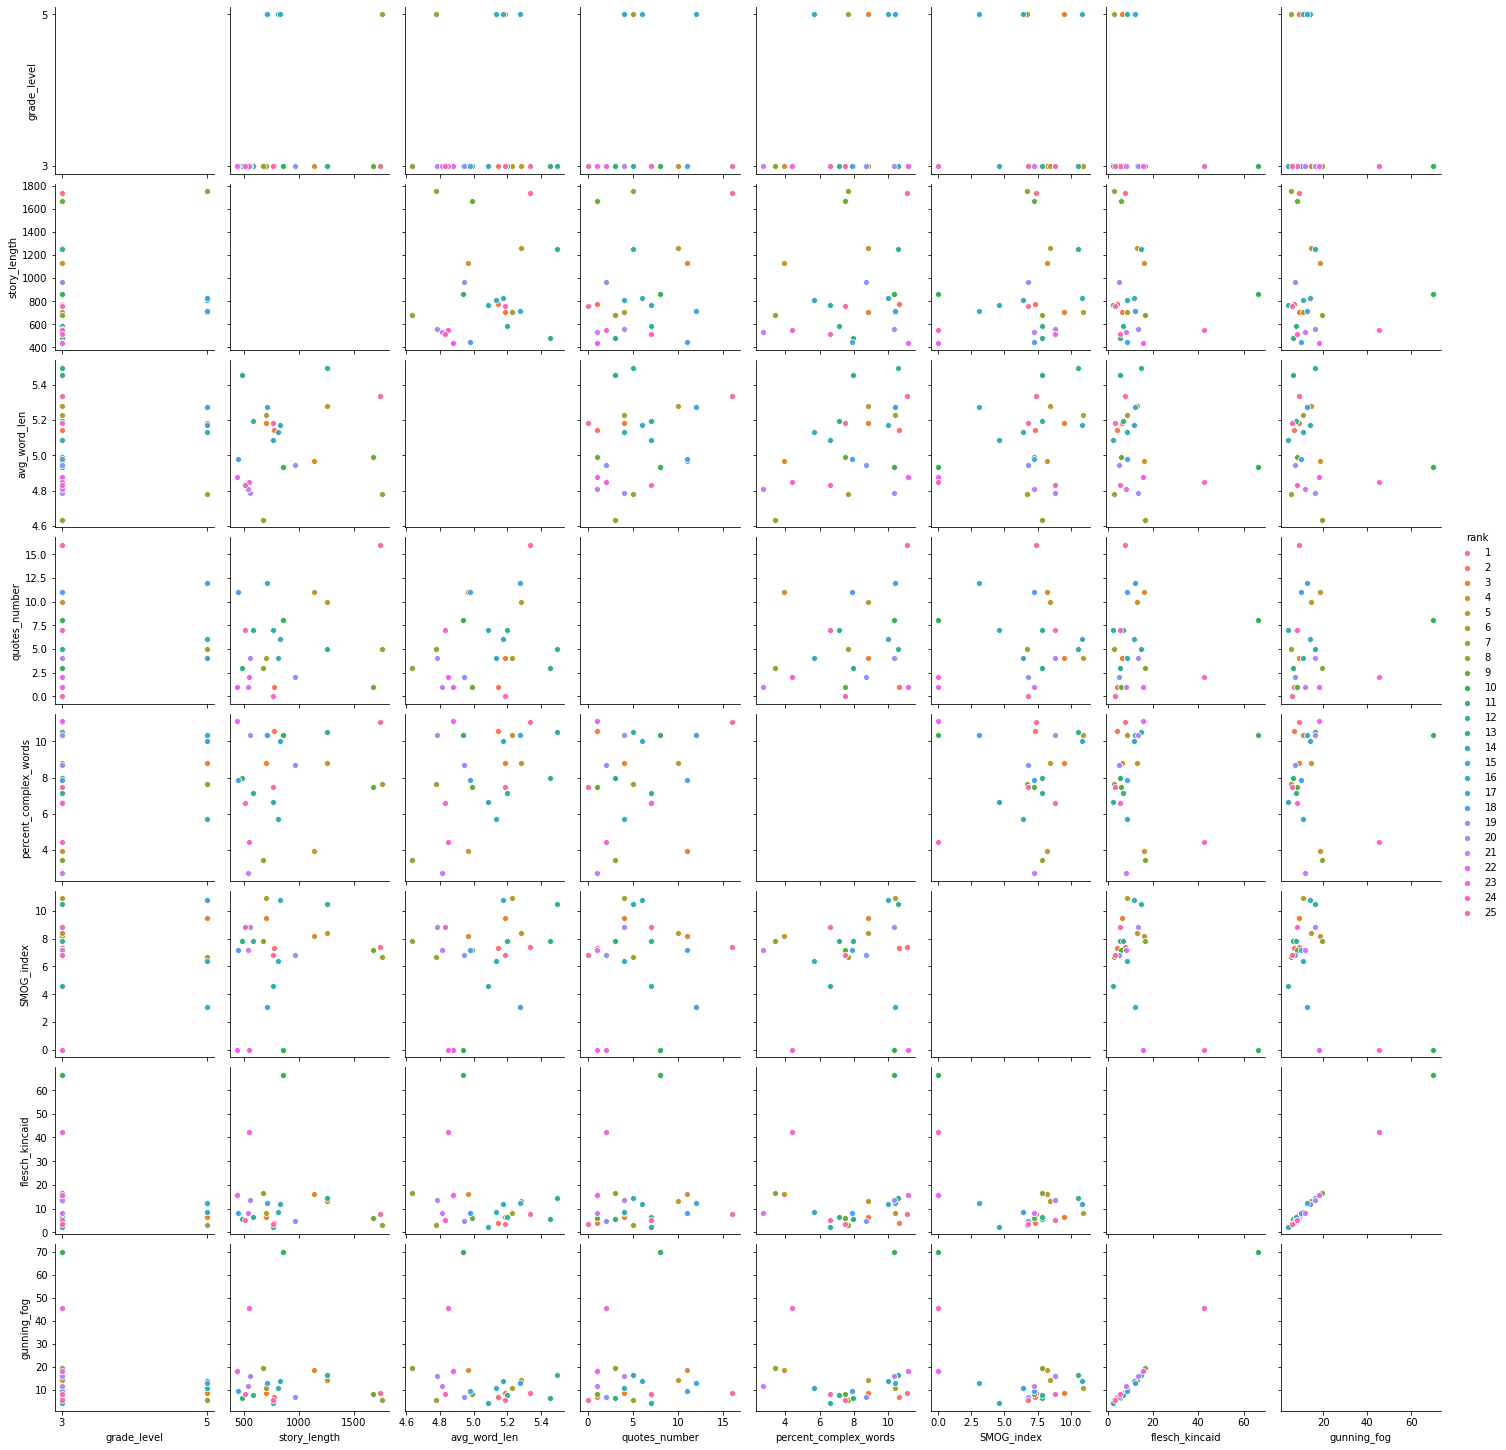

In [105]:
figure = sns.pairplot(ranked, hue='rank')


In [33]:
rest.head()

s_id                                         transcript grade_level  \
0  3132  Page. I 3132 Once there was a little cheatah a...           3   
1  3104  D she was very, a berenang The pony that didn'...           3   
2  3103  Rainbow the Unica unicom named some een Pearl ...           3   
3  3117  O gum drop land gumdrop. land is prace Were gu...           3   
4  3102  The secret fifth grade E am Anella I am starti...           3   

   story_length  avg_word_len  quotes_number  percent_complex_words  \
0          1375      5.092593              6               4.814815   
1           903      4.961538              0               7.692308   
2           750      5.000000              1               8.000000   
3           439      4.877778              1              11.111111   
4          1812      4.897297              0               9.459459   

   SMOG_index  flesch_kincaid  gunning_fog  
0         8.8            13.6        15.59  
1         6.6             5.0         7.45  
2         7.2             8.3        10.80  
3         0.0            15.7        18.05  
4         9.0             6.6         9.54

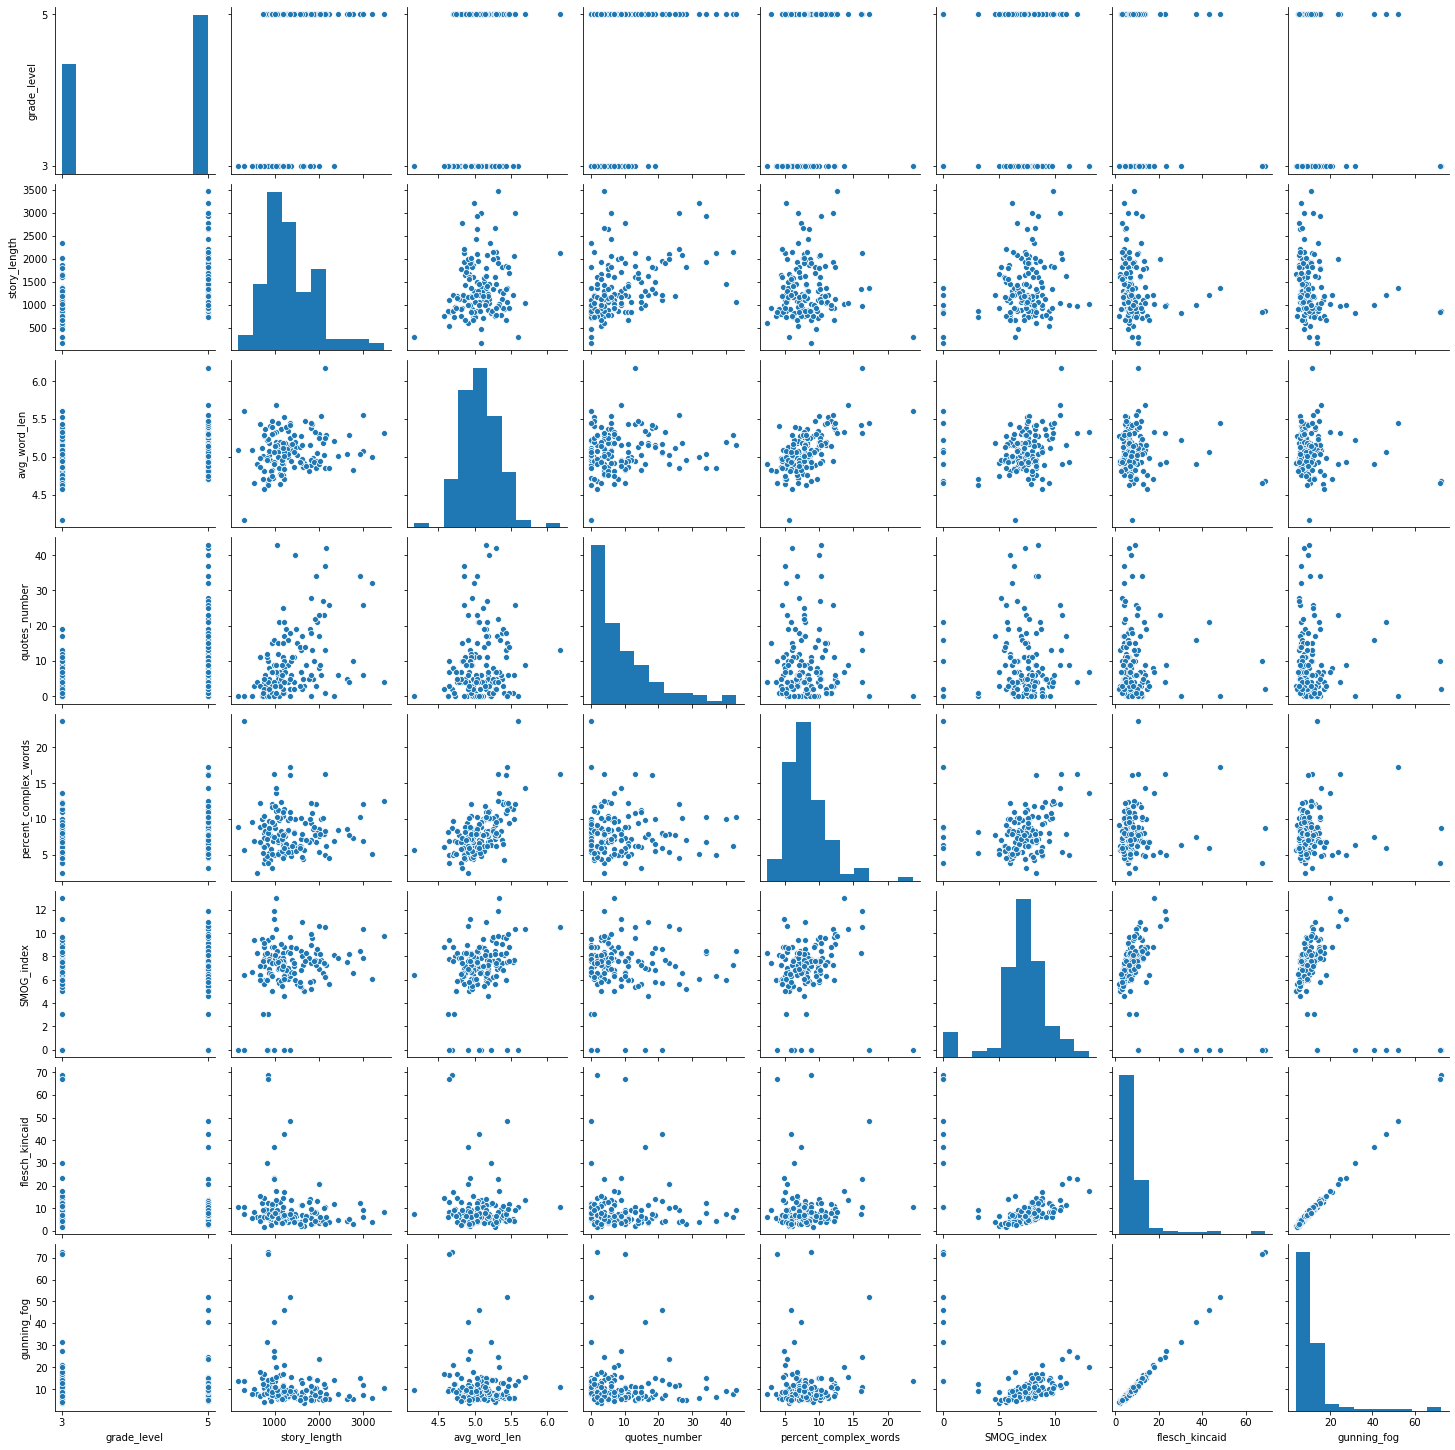

In [107]:
fig_rest = sns.pairplot(rest)

In [66]:
# dosent seem like there is much to be seen as a pattern

In [108]:
# requires the PunkSentenceTokenizer to be imported from nltk.tokenize
# tokenization function that pos tags the tokens after they are broken up
def t_function(x):
    """takes a document as input and returs a list of the part of speech tag tuples"""
    pos_tokens = []
    sentences = nltk.sent_tokenize(x)
    for sent in sentences:
        pos_tokens += (nltk.pos_tag(nltk.word_tokenize(sent)))
    return pos_tokens

def pos_sort(x, pos: str):
    """function to pull out a specific pos tag from a list of pos tokens"""
    out = []
    for word in x:
        if pos in word[1]:
            out.append(word)
    return out

In [109]:
pos_tokens = metrics.transcript.apply(t_function)

In [110]:
pos_tokens[0][:15]

[('Page', 'NN'),
 ('.', '.'),
 ('I', 'PRP'),
 ('3132', 'CD'),
 ('Once', 'RB'),
 ('there', 'EX'),
 ('was', 'VBD'),
 ('a', 'DT'),
 ('little', 'JJ'),
 ('cheatah', 'NN'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('cheatah', 'NN'),
 ('had', 'VBD'),
 ('a', 'DT')]

In [111]:
metrics["pos_tokens"] = pos_tokens

In [112]:
def derive_pos_tags(df: pd.DataFrame, token_col_name: str, tags:list):
    """
    takes various counts and ratios for the diffrent POS tags and adds them to df
    Arguments:
    ----------
    df: dataframe with `atleast` a transcription column comprised of one string

    t_col_name: transcription column name
    
    tags: list of pos tags to search for and count
    returns pd.DataFrame: a data frame with the added columns
    """
    df = df.copy()
    ratio_cols = []
    for tag in tags:
        # pull the pos tag out of the pos tokens column
        df[f"{tag}_tokens"] = df[token_col_name].apply(pos_sort ,args=(tag,))
        # count the tokens that are4 returned from the above function call
        df[f"{tag}_count"] = df[f"{tag}_tokens"].apply(len)
        # calculate the ratio of tag tokens present
        # in the document compared to the total number of words 
        df[f"{tag}_ratio_to_total"] = pd.Series(df[f"{tag}_count"].to_numpy()/df["story_length"].to_numpy())
        # useful list of ratios col names
        ratio_cols.append(f"{tag}_ratio_to_total")
    ratio_sums = []
    # for each row in the dataset take the sum the pos ratios that are passed
    for n in range(df.shape[0]):
        ratio_sums.append(sum(df[ratio_cols].iloc[n]))
    df["ratio_sums"] = pd.Series(ratio_sums)
    return df

In [113]:
metrics = derive_pos_tags(metrics, token_col_name="pos_tokens", tags=["JJ","NN","RB","TO","UH"])

In [33]:
metrics.head()

s_id                                         transcript grade_level  \
0  3132  Page. I 3132 Once there was a little cheatah a...           3   
1  3104  D she was very, a berenang The pony that didn'...           3   
2  3103  Rainbow the Unica unicom named some een Pearl ...           3   
3  3117  O gum drop land gumdrop. land is prace Were gu...           3   
4  3102  The secret fifth grade E am Anella I am starti...           3   

   story_length  avg_word_len  quotes_number  percent_complex_words  \
0          1375      5.092593              6               4.814815   
1           903      4.961538              0               7.692308   
2           750      5.000000              1               8.000000   
3           439      4.877778              1              11.111111   
4          1812      4.897297              0               9.459459   

   SMOG_index  flesch_kincaid  gunning_fog  ...  \
0         8.8            13.6        15.59  ...   
1         6.6             5.0         7.45  ...   
2         7.2             8.3        10.80  ...   
3         0.0            15.7        18.05  ...   
4         9.0             6.6         9.54  ...   

                                           RB_tokens RB_count  \
0  [(Once, RB), (always, RB), (always, RB), (here...       12   
1  [(very, RB), (n't, RB), (Once, RB), (why, WRB)...       12   
2  [(very, RB), (absolutly, RB), (back, RB), (ber...        8   
3                           [(ever, RB), (back, RB)]        2   
4  [(n't, RB), (when, WRB), (how, WRB), (long, RB...       25   

   RB_ratio_to_total                                          TO_tokens  \
0           0.008727  [(to, TO), (to, TO), (to, TO), (to, TO), (to, ...   
1           0.013289  [(to, TO), (to, TO), (to, TO), (to, TO), (to, ...   
2           0.010667           [(to, TO), (to, TO), (to, TO), (to, TO)]   
3           0.004556                                         [(to, TO)]   
4           0.013797  [(to, TO), (to, TO), (to, TO), (to, TO), (to, ...   

  TO_count  TO_ratio_to_total  UH_tokens UH_count  UH_ratio_to_total  \
0       11           0.008000         []        0                0.0   
1        8           0.008859         []        0                0.0   
2        4           0.005333         []        0                0.0   
3        1           0.002278         []        0                0.0   
4       10           0.005519         []        0                0.0   

   ratio_sums  
0    0.082909  
1    0.085271  
2    0.070667  
3    0.095672  
4    0.088852  

[5 rows x 27 columns]

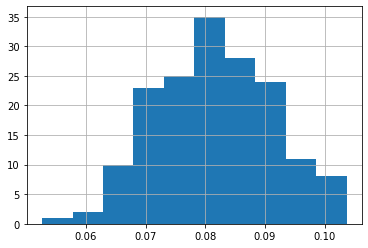

In [27]:
metrics.ratio_sums.hist()

In [114]:
ranked, rest = organize_by_ranking(metrics, rankings)

In [33]:
ranked.select_dtypes(exclude="object")

story_length  avg_word_len  quotes_number  percent_complex_words  \
3101           439      4.877778              1              11.111111   
3105           768      5.086093              7               6.622517   
3106          1253      5.495614              5              10.526316   
3108           969      4.943878              2               8.673469   
3110          1133      4.969298             11               3.947368   
3111           548      4.849558              2               4.424779   
3112           762      5.183673              0               7.482993   
3117           677      4.636986              3               3.424658   
3118           555      4.784483              4              10.344828   
3119           582      5.196429              7               7.142857   
3120           534      4.810811              1               2.702703   
3121           859      4.936782              8              10.344828   
3122           512      4.830189              7               6.603774   
3125           480      5.454545              3               7.954545   
3126          1672      4.991045              1               7.462687   
3127           706      5.229630              4              10.370370   
3128          1734      5.335385             16              11.076923   
3129           777      5.145695              1              10.596026   
3130           443      4.977528             11               7.865169   
3131          1257      5.281513             10               8.823529   
5101           705      5.183824              4               8.823529   
5103           828      5.175000              6              10.000000   
5104          1754      4.779292              5               7.629428   
5108           712      5.274074             12              10.370370   
5109           811      5.132911              4               5.696203   

      SMOG_index  flesch_kincaid  gunning_fog  JJ_count  JJ_ratio_to_total  \
3101         0.0            15.7        18.05         3           0.006834   
3105         4.6             2.4         4.15         5           0.006510   
3106        10.5            14.6        16.43         4           0.003192   
3108         6.8             4.9         6.93         7           0.007224   
3110         8.2            16.2        18.61        10           0.008826   
3111         0.0            42.3        45.51         5           0.009124   
3112         6.8             3.4         5.74         8           0.010499   
3117         7.8            16.4        19.48         6           0.008863   
3118         8.8            13.5        16.02         7           0.012613   
3119         7.8             6.6         7.76        10           0.017182   
3120         7.2             8.2        11.48         7           0.013109   
3121         0.0            66.4        70.06         9           0.010477   
3122         8.8             5.3         8.05         5           0.009766   
3125         7.8             5.5         6.33         7           0.014583   
3126         7.2             5.8         8.16        12           0.007177   
3127        10.9             8.3        10.92         3           0.004249   
3128         7.4             7.5         8.81        21           0.012111   
3129         7.3             3.9         6.80        11           0.014157   
3130         7.2             8.3         9.64         6           0.013544   
3131         8.4            13.0        14.44        12           0.009547   
5101         9.5             6.3         8.83         8           0.011348   
5103        10.8            11.8        13.95        13           0.015700   
5104         6.7             2.9         5.42        13           0.007412   
5108         3.1            12.2        12.80         2           0.002809   
5109         6.4             8.6        10.84         6           0.007398   

      NN_count  NN_ratio_to_total  RB_count  RB_rati

In [34]:
rest.sample(15).select_dtypes(exclude='object')

story_length  avg_word_len  quotes_number  percent_complex_words  \
5204          1991      4.903941             23               5.418719   
3209           755      5.279720              2               9.090909   
3235          1183      4.949791              1               4.602510   
3237           814      5.217949              0               6.410256   
5113          1567      4.927673              3               5.974843   
5240           767      5.289655              5              10.344828   
5209          1105      5.163551             21               7.943925   
5254          2217      4.851204             26               4.595186   
3123           747      4.980000              0               7.333333   
5213          1625      5.158730             17               7.936508   
3201          1306      5.042471              4               5.405405   
3203           296      4.169014              0               5.633803   
3222          1215      5.522727              1              11.363636   
3234          1355      5.152091              2              11.026616   
3202          1219      4.706564              8               5.019305   

      SMOG_index  flesch_kincaid  gunning_fog  JJ_count  JJ_ratio_to_total  \
5204        10.6            20.8        23.70        15           0.007534   
3209         5.6             2.0         4.37         7           0.009272   
3235         6.1             7.0         8.85        13           0.010989   
3237         0.0            30.0        31.77         9           0.011057   
5113         5.8             3.0         5.08        21           0.013401   
5240         9.2             6.0         7.76        20           0.026076   
5209         5.7             4.0         6.17        13           0.011765   
5254         5.6             4.0         5.83        18           0.008119   
3123         7.8             8.2        10.42         4           0.005355   
5213        11.0            11.6        12.95         9           0.005538   
3201         8.4             5.6         8.15         7           0.005360   
3203         6.4             7.7         9.89         1           0.003378   
3222         7.5             5.4         5.85        10           0.008230   
3234         6.3             6.4         8.54        17           0.012546   
3202         8.8            17.4        20.87        15           0.012305   

      NN_count  NN_ratio_to_total  RB_count  RB_ratio_to_total  TO_count  \
5204       124           0.062280        20           0.010045        11   
3209        50           0.066225        10           0.013245         1   
3235        61           0.051564        17           0.014370         8   
3237        46           0.056511        14           0.017199         2   
5113        91           0.058073        27           0.017230         8   
5240        44           0.057366         9           0.011734         1   
5209        53           0.047964        21           0.019005        11   
5254        73           0.032927        45           0.020298        15   
3123        53           0.070950         2           0.002677         3   
5213        91           0.056000        26           0.016000         7   
3201        67           0.051302        25           0.019142         9   
3203        18           0.060811         4           0.013514         2   
3222        61           0.050206        16           0.013169         2   
3234        77           0.056827        15           0.011070         6   
3202        65           0.053322        13           0.010664        11   

      TO_ratio_to_total  UH_count  UH_ratio_to_total  ratio_sums  
5204           0.005525         0           0.000000    0.085384  
3209           0.001325         1           0.001325    0.091391  
3235           0.006762         0           0.000000    0.083686  
3237           0.002457         0           0.000000    0.087224  
5113           0.005

In [115]:
ranked.corr()[ranked.corr()['rank'].values < 0]

story_length  avg_word_len  quotes_number  \
story_length               1.000000      0.170846       0.288018   
avg_word_len               0.170846      1.000000       0.280723   
quotes_number              0.288018      0.280723       1.000000   
percent_complex_words      0.161942      0.483906       0.199650   
SMOG_index                 0.182474      0.310997       0.048454   
JJ_count                   0.683224      0.133838       0.349659   
JJ_ratio_to_total         -0.272513     -0.021573       0.005478   
NN_count                   0.884486      0.219772       0.321765   
RB_count                   0.768920      0.028333      -0.027544   
TO_count                   0.664619     -0.364355       0.155504   
UH_count                   0.181684      0.146945      -0.223883   

                       percent_complex_words  SMOG_index  flesch_kincaid  \
story_length                        0.161942    0.182474       -0.111357   
avg_word_len                        0.483906    0.310997       -0.224756   
quotes_number                       0.199650    0.048454        0.089885   
percent_complex_words               1.000000    0.024626        0.022504   
SMOG_index                          0.024626    1.000000       -0.611097   
JJ_count                            0.133902    0.232163       -0.094906   
JJ_ratio_to_total                  -0.087514    0.198147       -0.047510   
NN_count                            0.225795    0.144789       -0.077510   
RB_count                           -0.073672    0.215818       -0.261361   
TO_count                           -0.211557    0.029166       -0.179928   
UH_count                            0.180006    0.324639       -0.082928   

                       gunning_fog  JJ_count  JJ_ratio_to_total  NN_count  \
story_length             -0.113567  0.683224          -0.272513  0.884486   
avg_word_len             -0.254792  0.133838          -0.021573  0.219772   
quotes_number             0.060221  0.349659           0.005478  0.321765   
percent_complex_words     0.005098  0.133902          -0.087514  0.225795   
SMOG_index               -0.605051  0.232163           0.198147  0.144789   
JJ_count                 -0.096496  1.000000           0.468322  0.623103   
JJ_ratio_to_total        -0.046810  0.468322           1.000000 -0.315204   
NN_count                 -0.076990  0.623103          -0.315204  1.000000   
RB_count                 -0.257651  0.659628           0.035225  0.577851   
TO_count                 -0.170416  0.467876          -0.159479  0.491431   
UH_count                 -0.076921 -0.196589          -0.383925  0.297224   

                       NN_ratio_to_total  RB_count  RB_ratio_to_total  \
story_length                   -0.380397  0.768920          -0.083944   
avg_word_len                   -0.088914  0.028333           0.025865   
quotes_number                  -0.132563 -0.027544          -0.300425   
percent_complex_words           0.148292 -0.073672          -0.350958   
SMOG_index                     -0.237721  0.215818           0.197163   
JJ_count                       -0.325680  0.659628           0.199268   
JJ_ratio_to_total              -0.153459  0.035225           0.475691   
NN_count                        0.060649  0.577851          -0.256928   
RB_count                       -0.480370  1.000000           0.516873   
TO_count                       -0.382207  0.594477           0.021994   
UH_count                        0.212006 -0.005592          -0.263104   

                       TO_count  TO_ratio_to_total  UH_count  \
story_length           0.664619           0.042959  0.181684   
avg_word_len          -0.364355          -0.621785  0.146945   
quotes_number          0.155504          -0.030145 -0.223883   
percent_complex_words -0.211557          -0.461419  0.180006   
SMOG_index             0.029166          -0.013982  0.324639   
JJ_count               0.467876           0.030517 -0.196589   
JJ_ratio_to_total     -0.159479           0

In [116]:
ranked.corr()

story_length  avg_word_len  quotes_number  \
story_length               1.000000      0.170846       0.288018   
avg_word_len               0.170846      1.000000       0.280723   
quotes_number              0.288018      0.280723       1.000000   
percent_complex_words      0.161942      0.483906       0.199650   
SMOG_index                 0.182474      0.310997       0.048454   
flesch_kincaid            -0.111357     -0.224756       0.089885   
gunning_fog               -0.113567     -0.254792       0.060221   
JJ_count                   0.683224      0.133838       0.349659   
JJ_ratio_to_total         -0.272513     -0.021573       0.005478   
NN_count                   0.884486      0.219772       0.321765   
NN_ratio_to_total         -0.380397     -0.088914      -0.132563   
RB_count                   0.768920      0.028333      -0.027544   
RB_ratio_to_total         -0.083944      0.025865      -0.300425   
TO_count                   0.664619     -0.364355       0.155504   
TO_ratio_to_total          0.042959     -0.621785      -0.030145   
UH_count                   0.181684      0.146945      -0.223883   
UH_ratio_to_total         -0.004452      0.045435      -0.180585   
ratio_sums                -0.501927     -0.245160      -0.303114   
rank                      -0.547640     -0.318545      -0.339448   

                       percent_complex_words  SMOG_index  flesch_kincaid  \
story_length                        0.161942    0.182474       -0.111357   
avg_word_len                        0.483906    0.310997       -0.224756   
quotes_number                       0.199650    0.048454        0.089885   
percent_complex_words               1.000000    0.024626        0.022504   
SMOG_index                          0.024626    1.000000       -0.611097   
flesch_kincaid                      0.022504   -0.611097        1.000000   
gunning_fog                         0.005098   -0.605051        0.998816   
JJ_count                            0.133902    0.232163       -0.094906   
JJ_ratio_to_total                  -0.087514    0.198147       -0.047510   
NN_count                            0.225795    0.144789       -0.077510   
NN_ratio_to_total                   0.148292   -0.237721        0.080324   
RB_count                           -0.073672    0.215818       -0.261361   
RB_ratio_to_total                  -0.350958    0.197163       -0.232671   
TO_count                           -0.211557    0.029166       -0.179928   
TO_ratio_to_total                  -0.461419   -0.013982       -0.122207   
UH_count                            0.180006    0.324639       -0.082928   
UH_ratio_to_total                   0.208193    0.317140       -0.062648   
ratio_sums                         -0.176723   -0.058550       -0.091976   
rank                               -0.185505   -0.323771        0.063661   

                       gunning_fog  JJ_count  JJ_ratio_to_total  NN_count  \
story_length             -0.113567  0.683224          -0.272513  0.884486   
avg_word_len             -0.254792  0.133838          -0.021573  0.219772   
quotes_number             0.060221  0.349659           0.005478  0.321765   
percent_complex_words     0.005098  0.133902          -0.087514  0.225795   
SMOG_index               -0.605051  0.232163           0.198147  0.144789   
flesch_kincaid            0.998816 -0.094906          -0.047510 -0.077510   
gunning_fog               1.000000 -0.096496          -0.046810 -0.076990   
JJ_count                 -0.096496  1.000000           0.468322  0.623103   
JJ_ratio_to_total        -0.046810  0.468322           1.000000 -0.315204   
NN_count                 -0.076990  0.623103          -0.315204  1.000000   
NN_ratio_to_total         0.090278 -0.325680          -0.153459  0.060649   
RB_count                 -0.257651  0.659628           0.035225  0.577851   
RB_ratio_to_total        -0.229999  0.199268           0.475691 -0.256928   
TO_count                 -0.170416  0.467876          -0.159479

In [119]:
px.parallel_coordinates(ranked.select_dtypes(exclude='object').drop(["JJ_ratio_to_total","NN_ratio_to_total","TO_ratio_to_total","UH_ratio_to_total", "RB_ratio_to_total"], axis=1), color='rank')


In [122]:
px.density_contour(data_frame=ranked, y="JJ_count", x="rank", color="JJ_ratio_to_total")

In [206]:
class DummyScalar():
    def fit_transform(self, X):
        return X

def squad_score(df, features, scalars, weights, scalar):
    raw = []
    df = df.copy()
    try:
        subset = df[features]
        subset = pd.DataFrame(scalar.fit_transform(subset), columns=features)
        print("psubset_scaled head\n\n", subset.head())
    except Exception as e:
        print(e)
    
    assert len(scalars) == len(weights)
    
    print("\n\nbegin loop\n\n")
    for f, w, s in zip(features, weights, scalars):
        print(f,w,s,end='\n\n')
        raw.append((subset[f] * (w * np.abs(s))).values)
    
    print("\n\nRaw:\n\n",raw)
    s_score = sum(raw)
    print("\n\n",s_score)
    return s_score



In [207]:
ss = DummyScalar()


In [224]:
Squad_score = squad_score(ranked, features, scalars, weights, ss)

psubset_scaled head

       story_length  avg_word_len  quotes_number  percent_complex_words  \
s_id                                                                     
3101          1672      4.991045              1               7.462687   
3105           768      5.086093              7               6.622517   
3106           480      5.454545              3               7.954545   
3108           706      5.229630              4              10.370370   
3110           534      4.810811              1               2.702703   

      SMOG_index  JJ_count  JJ_ratio_to_total  NN_count  RB_count  TO_count  \
s_id                                                                          
3101         7.2        12           0.007177        71        30         8   
3105         4.6         5           0.006510        41         4         3   
3106         7.8         7           0.014583        18        15         1   
3108        10.9         3           0.004249        54         

In [238]:
ranked["squad_score"] = pd.Series(Squad_score, index=ranked.index)

In [245]:
px.scatter(data_frame=ranked, x="squad_score", y='rank', width=1200)

### scalling the weight by the absoulte value of the corrilation coefficiant; squared

$$W_{n} = \bigg|{ Corr(F)}\bigg|^{2} \cdot W_{n} $$ 

### Taking the sum of the scalled (F)eature Metrics times the (W)eights for each metric/weight in length of features
$$SScore(x, F | W) = \sum_{n=1}^{i < len(F)} F_{i} \cdot W_{i}$$


read: SScore of x in respect to features given weights is equal to the sum of features times weights for feature in features

In [166]:
# refine the corr table to only negitive coefficants
corr_table = ranked.corr()[ranked.corr()['rank'].values < 0]
features = corr_table.index.to_list()

# get the Corr Coefficants that are related to Rank
scalars = corr_table['rank']
# clean it up and cast to list
scalars = scalars.apply(round, args=[5,]).to_list()

# init with ones, we will update these later
weights = np.ones(shape=(len(features,)))


In [167]:
features

['story_length',
 'avg_word_len',
 'quotes_number',
 'percent_complex_words',
 'SMOG_index',
 'JJ_count',
 'JJ_ratio_to_total',
 'NN_count',
 'RB_count',
 'TO_count',
 'UH_count']

In [168]:
scalars

[-0.54764,
 -0.31854,
 -0.33945,
 -0.18551,
 -0.32377,
 -0.54251,
 -0.03795,
 -0.59381,
 -0.40559,
 -0.21977,
 -0.02774]

In [169]:
weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])